In [1]:
%load_ext line_profiler
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
from ozone import Ozone
from load_ac import stack_antenna_ac
import h5py
import scipy


In [2]:
mir_data = MirParser("/Users/gkeating/data/SMA/ozone/211009_04:56:19", has_auto=True)
freq_range = [min(mir_data.sp_data['fsky']) - 2.0, max(mir_data.sp_data['fsky']) + 2.0]
ozone_model = Ozone('/Users/gkeating/newdata/')#, freq_range=freq_range)
pwv = 2
_ = ozone_model(zenith=0.1, pwv=pwv, return_pwv_jacobian=True)

In [3]:
with h5py.File('../src/data/10923_specsoln.mat') as compass_solns:
    bpArr = np.square(compass_solns['bandpassArr']).sum(axis=-1)
    freq_arr = np.divide(compass_solns['freqArr'], 1e9)
    scaleFac = np.swapaxes(np.asarray(compass_solns['gainApEff']).reshape(8, 2, -1), axis1=0, axis2=1)
    sbArr = compass_solns['sbArr'][0]
    winArr = compass_solns['winArr'][0]


# print("Idx | SB  | Chunk")
# print("-----------------")
cal_map = {}
for idx in range(12):
    pass
    # print(f" {idx:>2d} | {"USB" if sbArr[idx] == 1.0 else "LSB"} |   {int(winArr[idx])}")
    # cal_map[( )]

In [4]:
freqs, stacked, meta = stack_antenna_ac(
    mir_data,
    antenna_num=1,
    rx_num=0,
    normalization=False,
    return_meta=True,
    spw_baselining=False,
    mad_dev=15.0,
    window_size=11,
)

In [5]:
pwv=2.0
mir_data.select(reset=True)
elevation = mir_data.eng_data.get_value("actual_el", where=("antenna", "eq", 1))

model_arr = np.zeros_like(stacked)
delta_arr = np.zeros_like(stacked)

za_arr = np.radians(90 - elevation)
model_freqs = ozone_model.data['freq']['map']
nspws = stacked.shape[1]
gain_fac = np.array([1.1, 0.9])[:, None]
for idx, zenith in enumerate(za_arr):
    model_temps, delta_temps = ozone_model(pwv=pwv, zenith=zenith, return_pwv_jacobian=True, freq_arr=freqs)
    model_arr[idx] = (model_temps * gain_fac).sum(axis=1)
    delta_arr[idx] = (delta_temps * gain_fac).sum(axis=1)

(294, 6, 14336)


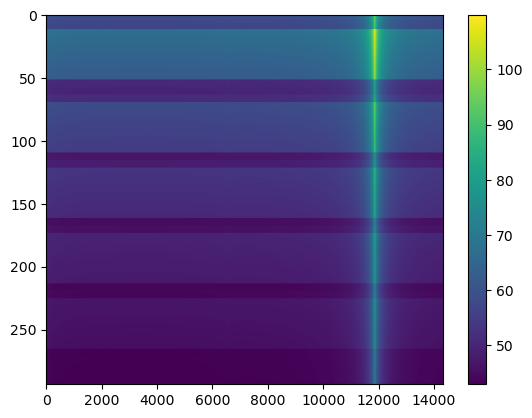

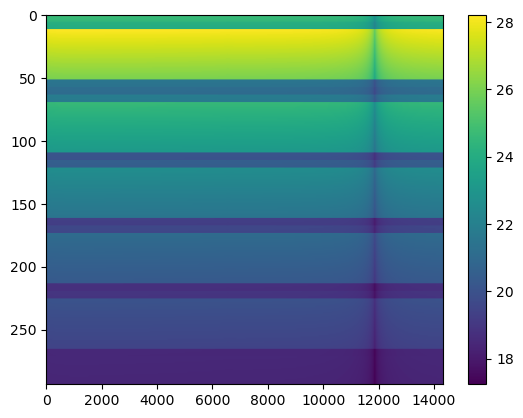

In [12]:
print(model_arr.shape)
plt.figure()
plt.imshow(model_arr[:, 0, :], aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow(delta_arr[:, 0, :], aspect='auto')
plt.colorbar()
